# ML_03_02_Walkthrough_Clustering

### Importing libraries

In [1]:
## Importing libraries needed to create data and visualise it
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

##Optional libraries if you want to remove the Warnings while implementing the models:
#import warnings
#warnings.filterwarnings('ignore')

### Defining functions to visualise the clusters

In [2]:
from scipy.spatial.distance import cdist
##Creating a method to visualise the centroids area of influence
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [3]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

<hr style="border:2px solid black"> </hr>

## K-Means

In [4]:
## Creating some datapoints to analyse
#from sklearn.datasets.samples_generator import make_blobs #old version
from sklearn.datasets import make_blobs ##newest version

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

##lets look a sample of the data
X[0:10] 

array([[ 0.83685684,  2.13635938],
       [-1.4136581 ,  7.40962324],
       [ 1.15521298,  5.09961887],
       [-1.01861632,  7.81491465],
       [ 1.27135141,  1.89254207],
       [ 3.43761754,  0.26165417],
       [-1.80822253,  1.59701749],
       [ 1.41372442,  4.38117707],
       [-0.20493217,  8.43209665],
       [-0.71109961,  8.66043846]])

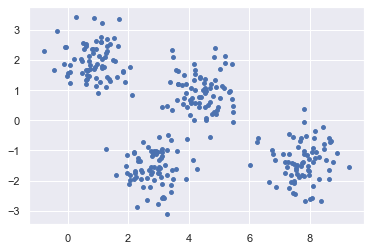

In [5]:
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:, 0], X[:, 1], s=15)

We can identify 4 cluster without much analysis

In [6]:
##Import the library to implement K-means
##Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans

#Creating the deffinition of the model
kmeans = KMeans(n_clusters=4)

#Training the model to a particular dataset
kmeans.fit(X)

#Assigning the "labels" with the model defined and trained before
y_kmeans = kmeans.predict(X)

In [7]:
#Looking at the clusters assigned to the data points
y_kmeans[0:10]

array([1, 0, 2, 0, 1, 1, 3, 2, 0, 0])

In [8]:
##Centroids coordenates 
kmeans.cluster_centers_
centers = kmeans.cluster_centers_

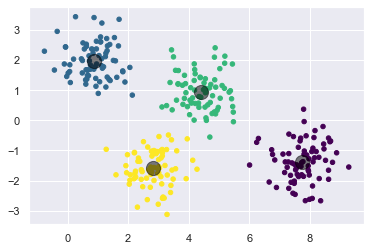

In [9]:
##Visualising the clusters centroids:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

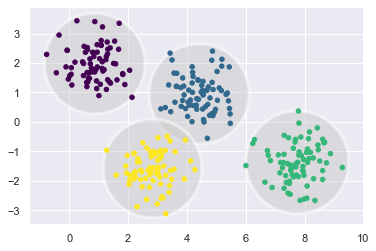

In [27]:
## Visualising cluster areas
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

<hr style="border:2px solid black"> </hr>

## K means - method evaluation:
### Elbow method

In [11]:
##Evaluating th inertia for a single K
print('The inertia of K-means K=4 is:', kmeans.inertia_)

The inertia of K-means K=4 is: 212.00599621083478


In [12]:
## Store the inertia metric value given different Ks and display the output:
inertia = []
#Range of the different values of K to analyse
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    inertia.append(km.inertia_)
    
##Printing the inertia values for each K
inertia

[1190.7823593643443,
 546.8911504626299,
 212.00599621083478,
 188.77323556773717,
 171.31030696288522,
 152.57704663465884,
 136.5582591783924,
 124.60248720428687]

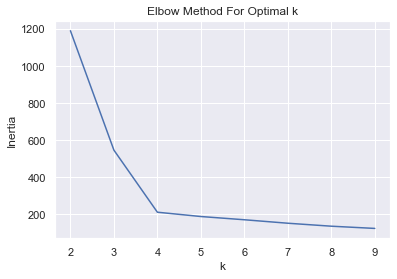

In [13]:
##Ploting the inertias for each K value: 
plt.plot(K, inertia)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

<hr style="border:2px solid black"> </hr>

### Silhouette Scores

In [14]:
##Evaluating the Silhouette Score for a single K
##Import the library to calculate the silhouette score
##Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
from sklearn.metrics import silhouette_score
print('The Silhouette Score of Kmeans K = 4 is:', silhouette_score(X, kmeans.labels_))

The Silhouette Score of Kmeans K = 4 is: 0.6819938690643478


In [15]:
## Store the silhouette score value given different Ks and display the output:
from sklearn.metrics import silhouette_score
## List to store the metric value given different K values
s_score = []
#Range of the different values of K to analyse
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    s_score.append(silhouette_score(X, kmeans.labels_))
    
s_score

[0.5426422297358302,
 0.5890390393551769,
 0.6819938690643478,
 0.5923875148758644,
 0.49356873858906275,
 0.42234389881547685,
 0.3290879342207915,
 0.3409786029219247]

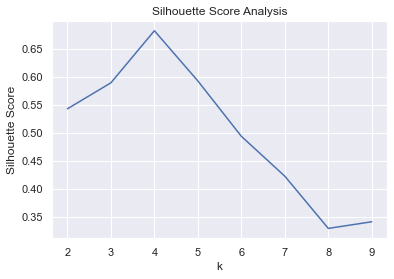

In [16]:
##Plotting the values of the metric
plt.plot(K, s_score)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')
plt.show()

<hr style="border:2px solid black"> </hr>

## Gaussian Mixture Models

In [17]:
##Lets implement the GMM to the data sample created
##Reference: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
from sklearn.mixture import GaussianMixture as GMM
##Creating the GMM model with 4 components
gmm = GMM(n_components=4, random_state=42).fit(X)
gmm


GaussianMixture(n_components=4, random_state=42)

In [18]:
##Lets assign a label to the dataset created
labels = gmm.predict(X)
labels

array([1, 0, 2, 0, 1, 1, 3, 2, 0, 0, 3, 0, 2, 0, 1, 2, 2, 1, 3, 3, 1, 1,
       2, 3, 3, 2, 1, 2, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 2, 3, 2, 2,
       3, 3, 0, 3, 0, 1, 3, 1, 0, 1, 1, 3, 0, 3, 0, 1, 0, 2, 0, 3, 3, 3,
       0, 1, 0, 3, 2, 3, 0, 3, 3, 0, 3, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2,
       0, 0, 2, 1, 0, 3, 3, 2, 1, 1, 2, 3, 0, 1, 0, 1, 2, 1, 1, 2, 0, 2,
       3, 3, 1, 0, 1, 2, 0, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 3,
       3, 1, 0, 3, 3, 0, 2, 0, 0, 3, 2, 3, 2, 3, 0, 2, 0, 0, 0, 2, 0, 2,
       1, 3, 0, 3, 1, 2, 0, 2, 2, 1, 2, 3, 3, 2, 1, 2, 2, 0, 1, 2, 3, 0,
       1, 1, 2, 3, 1, 2, 3, 3, 2, 2, 2, 2, 1, 0, 2, 3, 2, 2, 3, 3, 3, 2,
       3, 0, 2, 3, 1, 3, 2, 0, 3, 0, 2, 0, 2, 3, 2, 2, 0, 3, 3, 1, 1, 2,
       0, 1, 1, 3, 1, 3, 2, 0, 0, 2, 2, 0, 2, 1, 3, 2, 1, 3, 0, 3, 1, 2,
       1, 0, 0, 0, 0, 3, 3, 0, 2, 3, 1, 2, 3, 3, 3, 1, 1, 0, 2, 2, 3, 1,
       0, 3, 2, 0, 2, 1, 1, 3, 3, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1,
       0, 3, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 0, 3], d

In [19]:
## Probability of each point
probs = gmm.predict_proba(X)
probs[:5].round(3)

array([[0.   , 0.972, 0.026, 0.002],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.999, 0.001, 0.   ]])

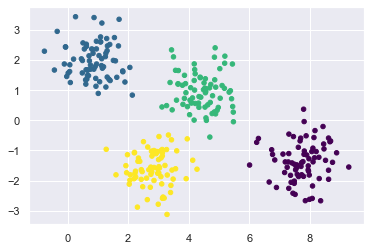

In [20]:
##Ploting the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis');

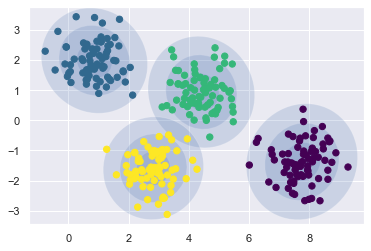

In [21]:
##Ploting the clusters and the areas of influence:
plot_gmm(gmm, X)

<hr style="border:2px solid black"> </hr>

## Model Evaluation - AIC and BIC

In [22]:
##Lets evaluate the model with this two indexes:
##AIC
gmm.aic(X)
##BIC
gmm.bic(X)

2036.4125079691319

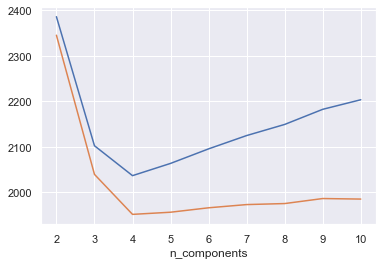

In [23]:
##Create the following graph that compares BIC and AIC for 2 to 10 components:
###Hints: 
###You can store the different models in a list and then extract the indexes values. 
###You can also explore list comprehensions.
n_components = range(2, 11)

models = [GMM(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.xlabel('n_components');

## AIC vs BIC

- Both penalise models that have more parameters to learn (e.g. more clusters) and reward models that fit the data well. They often end up selecting the same model. When they differ, the model selected by BIC tends to be simpler (fewer parameters) than the one selected by the AIC, but tends to not fit the data quite as well (specially for larger datasets).

<hr style="border:2px solid black"> </hr>

## K-Means vs GMM

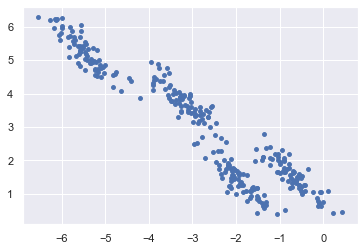

In [24]:
##Lets create some data with a different shape to compare both clustering algorithms:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
##Visualising the data
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], s=15)

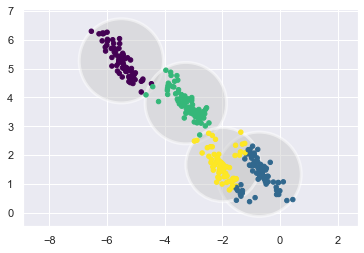

In [25]:
##Training K-means with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
##Visualising the clusters and area of influence:
plot_kmeans(kmeans, X_stretched)

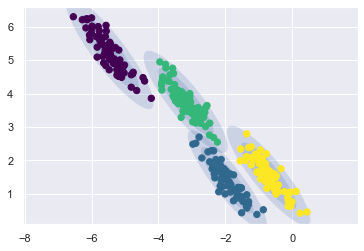

In [26]:
##Training a GMM model with 4 components
gmm = GMM(n_components=4,  random_state=42)
##Visualising the clusters and area of influence:
plot_gmm(gmm, X_stretched)

- K-means is fast and scalable but it does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes. It is important to scale (normalise) the input features before K-means; it generally improves things.

<hr style="border:2px solid black"> </hr>

## Exercise: 

- Replicate the excercise creating new data points(different centers values, std, sample size, etc.). Evaluate both methods with different k/components(e.g. from 2 to 20). 
- What about if you standardise the data? is there any change? 
- Document your findings